# DESI mini end-to-end test

Test end-to-end dataflow using a small number of tiles.<br/>
November 2017

## Basic setup to run this yourself at NERSC ##

On cori.nersc.gov, clone two_percent_DESI:
```
git clone https://github.com/desihub/two_percent_DESI
```
If needed, checkout the branch with the version you'd like to test, e.g.
```
cd two_percent_DESI
git checkout automini
```
This notebook and its configuration files are in `two_percent_DESI/mini`.

Configure the desi-17.9 jupyter notebook kernel for your account following the instructions at
https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC.  Then go to https://jupyter-dev.nersc.gov,
navigate to where you checked out `two_percent_DESI/mini` and start your own copy of this notebook.

To get the same version of code with an interactive login:
```console
source /project/projectdirs/desi/software/desi_environment.sh 17.9
```
(or `desi_environment.csh` for t/csh users)

### Running this notebook ###

Some steps of this notebook directly spawn batch jobs and wait for them to finish.  Unlike earlier versions, this is now automated and you don't have to cut-and-paste commands into a terminal for those steps.  These steps log to a different file so that the notebook isn't cluttered with N>>1 lines of output.  Steps that take more than a few minutes should indicate how long they expect to take and when they started.  Go check the logfile and/or run `squeue -u $USER` from a command line to check on things if you think they are stuck.

If everything runs successfully with minimal queue wait times, the entire notebook should run end-to-end in less than 2 hours.  Each step automatically recognizes whether it has already been successfully run and skips expensive processing steps if they aren't needed.  Thus if you need to restart, you can always just start from the very beginning and it will quickly catch up to the next substantive step to do.

If you want to force reprocessing of everything, remove `$SCRATCH/desi/dev/end2end/` and then restart the notebook from the beginning.



In [1]:
import os, sys, glob, time, subprocess, time
import numpy as np
import healpy as hp
from astropy.table import Table
import fitsio
%pylab inline

#- Some of these are imported just to establish versions but aren't used in the notebook itself
import desimodel.io
import desimodel.footprint
import desisurvey
import surveysim
import specsim
import desiutil.depend

print("Starting at {}".format(time.asctime()))
start_time = time.time()

Populating the interactive namespace from numpy and matplotlib
Starting at Sun Nov  5 09:15:04 2017


## Define the code versions used for this notebook

In [2]:
print('Starting at {}'.format(time.asctime()))
print(os.environ['DESIMODULES'])
deps = dict()
desiutil.depend.add_dependencies(deps)
desiutil.depend.setdep(deps, 'desisurvey', desisurvey.__version__)
desiutil.depend.setdep(deps, 'surveysim', surveysim.__version__)
for codename, version in desiutil.depend.iterdep(deps):
    print('  {:10s} {}'.format(codename, version))

Starting at Sun Nov  5 09:15:04 2017
/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desimodules/17.9
  python     3.5.3
  numpy      1.11.3
  astropy    1.3.3
  yaml       3.12
  matplotlib 2.0.2
  fitsio     0.9.11
  desiutil   1.9.7
  desimodel  0.9.0
  specsim    0.9
  desisurvey 0.9.2
  surveysim  0.8.1


## Set some environment variables and create output directories

The next cell will create directories under `$SCRATCH/desi/dev/end2end/` and set environment variables for this mapping:

| Directory             | NB variable   | Environment Variable                              |
|-----------------------|---------------|---------------------------------------------------|
| survey/               | surveydir     | \$DESISURVEY_OUTPUT                               |
| targets/              | targetdir     |                                                   |
| fiberassign/          | fibassigndir  |                                                   |
| spectro/redux/mini/   | reduxdir      | \$DESI_SPECTRO_REDUX/\$SPECPROD                   |
| spectro/sim/mini/     | simdatadir    | \$DESI_SPECTRO_DATA = \$DESI_SPECTRO_SIM/$PIXPROD |

It additionally derives the location of this `two_percent_DESI/mini/` directory as the notebook
variable `minitestdir` for use in later cells.


In [3]:
basedir = os.path.join(os.environ['SCRATCH'], 'desi', 'dev', 'end2end')
surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
targetdir = os.path.join(basedir, 'targets')
fibassigndir = os.path.join(basedir, 'fiberassign')
minitestdir = os.getcwd()

os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
os.environ['PIXPROD'] = 'mini'
os.environ['SPECPROD'] = 'mini'

reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
os.environ['DESI_SPECTRO_DATA'] = simdatadir

os.makedirs(surveydir, exist_ok=True)
os.makedirs(targetdir, exist_ok=True)
os.makedirs(fibassigndir, exist_ok=True)
os.makedirs(reduxdir, exist_ok=True)
os.makedirs(simdatadir, exist_ok=True)

if 'csh' in os.environ['SHELL']:
    envcmd = """\
source /project/projectdirs/desi/software/desi_environment.csh 17.9
set basedir = ${SCRATCH}/desi/dev/end2end
setenv DESISURVEY_OUTPUT ${basedir}/survey
setenv DESI_SPECTRO_REDUX ${basedir}/spectro/redux
setenv DESI_SPECTRO_SIM ${basedir}/spectro/sim
setenv SPECPROD mini
setenv PIXPROD mini
setenv DESI_SPECTRO_DATA ${DESI_SPECTRO_SIM}/${PIXPROD}
"""
else:
    envcmd = """\
source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}
"""
print('To recreate this environment from a login terminal:\n')
print(envcmd)

To recreate this environment from a login terminal:

source /project/projectdirs/desi/software/desi_environment.sh 17.9
basedir=${SCRATCH}/desi/dev/end2end
export DESISURVEY_OUTPUT=${basedir}/survey
export DESI_SPECTRO_REDUX=${basedir}/spectro/redux
export DESI_SPECTRO_SIM=${basedir}/spectro/sim
export SPECPROD=mini
export PIXPROD=mini
export DESI_SPECTRO_DATA=${DESI_SPECTRO_SIM}/${PIXPROD}



## Define a subset of tiles to use

In [4]:
alltiles = Table(desimodel.io.load_tiles())

#- Does tile subset already exist from an earlier run?
tilefile = os.path.join(targetdir, 'test-tiles.fits')
if os.path.exists(tilefile):
    print('Reading {}'.format(tilefile))
    tiles = Table.read(tilefile)
else:
    #- Make a subset of tiles to use
    ii = (150 < alltiles['RA']) & (alltiles['RA']<152) & (30<alltiles['DEC']) & (alltiles['DEC']<35)
    tiles = Table(alltiles[ii])

    #- Write two copies:
    #- one in two_percent_DESI/mini because that is where the surveysim config file will look, and
    #- one in $targetdir/ for later use by mpi_select_mock_targets
    tiles.write('test-tiles.fits', overwrite=True)
    tiles.write(tilefile, overwrite=True)

#- Show what tiles are in the subset
tiles

TILEID,RA,DEC,PASS,IN_DESI,EBV_MED,AIRMASS,STAR_DENSITY,EXPOSEFAC,PROGRAM,OBSCONDITIONS
int32,float64,float64,int16,int16,float32,float32,float32,float32,str6,int32
1165,150.69,33.86,0,1,0.0126537,1.02517,1416.73,1.11412,DARK,1
6927,151.78,33.84,1,1,0.0134791,1.02517,1402.3,1.11972,DARK,1
11108,150.87,31.23,1,1,0.0189035,1.02543,1451.67,1.15767,DARK,1
16870,151.96,31.21,2,1,0.0207586,1.02544,1403.42,1.17082,DARK,1
18465,150.47,33.2,3,1,0.0133246,1.02504,1433.89,1.11849,DARK,1
24227,151.56,33.18,4,1,0.0146741,1.02503,1410.88,1.12771,GRAY,2
28408,150.73,30.52,4,1,0.0196785,1.02587,1478.4,1.16376,GRAY,2
34170,151.82,30.5,5,1,0.0216828,1.02589,1414.49,1.17806,BRIGHT,4
39942,150.31,32.41,6,1,0.0144966,1.02505,1466.71,1.12651,BRIGHT,4


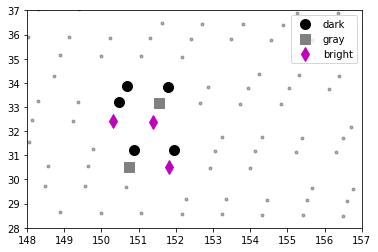

In [5]:
#- Plot those tiles
clf()
plot(alltiles['RA'], alltiles['DEC'], 'k.', alpha=0.3, label='_none_')
isdark = tiles['PROGRAM'] == 'DARK'
isgray = tiles['PROGRAM'] == 'GRAY'
isbright = tiles['PROGRAM'] == 'BRIGHT'
plot(tiles['RA'][isdark], tiles['DEC'][isdark], 'o', color='k', ms=10, label='dark')
plot(tiles['RA'][isgray], tiles['DEC'][isgray], 's', color='0.5', ms=10, label='gray')
plot(tiles['RA'][isbright], tiles['DEC'][isbright], 'd', color='m', ms=10, label='bright')
xlim(148, 157); ylim(28, 37)
legend()

## Run survey simulations on the subset of tiles

This will select a test subset of tiles in the NGC and run survey simulations for observations during March 2020.  These steps should take <5 minutes to run.

In [6]:
expfile = os.path.join(surveydir, 'exposures.fits')
if os.path.exists(expfile):
    print('Survey sims already done; skipping')
else:
    survey_logname = os.path.join(surveydir, 'survey.log')
    print('Running survey simulations; logging to {}'.format(survey_logname))
    with open(survey_logname, 'w') as logfile:
        cmd = "surveyinit --config-file ./desisurvey-config.yaml"
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0

        #- Use 0d fiber assignment delay to move on with mini sim quickly
        cmd = "surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --create --fa-delay 0d"
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0

        cmd = "surveysim --config-file ./desisurvey-config.yaml --seed 123"
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        assert err == 0

        plan_cmd = 'surveyplan --config-file ./desisurvey-config.yaml --rules rules-layers.yaml --fa-delay 0d'
        sim_cmd = 'surveysim --resume --config-file ./desisurvey-config.yaml --seed 123'
        while True:
            lastdate = open(os.path.join(surveydir, 'last_date.txt')).readline().strip()
            progress = Table.read(os.path.join(surveydir, 'progress.fits'), 1)
            ndone = np.count_nonzero(progress['status'] == 2)
            print('Starting {} with {}/{} tiles completed {}'.format(lastdate, ndone, len(progress), time.asctime()))
            if subprocess.call(plan_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                break
            if subprocess.call(sim_cmd.split(), stdout=logfile, stderr=logfile) != 0:
                break

    print('done observing')

Running survey simulations; logging to /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/survey.log
Starting 2020-03-16 with 4/10 tiles completed Sun Nov  5 09:15:31 2017
Starting 2020-03-17 with 7/10 tiles completed Sun Nov  5 09:15:41 2017
Starting 2020-03-18 with 7/10 tiles completed Sun Nov  5 09:15:45 2017
Starting 2020-03-19 with 9/10 tiles completed Sun Nov  5 09:15:50 2017
Starting 2020-03-20 with 10/10 tiles completed Sun Nov  5 09:15:56 2017
done observing


### Confirm that we got the expected output files before proceeding

In [7]:
progressfile = os.path.join(surveydir, 'progress.fits')
if not os.path.exists(progressfile):
    print("ERROR: Missing {}".format(progressfile))
    print("Check {} for what might have gone wrong".format(survey_logname))
    print()
    
print('Files in {}:\n'.format(surveydir))
!ls $surveydir

Files in /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey:

ephem_2020-03-15_2020-04-15.fits  plan_2020-03-19_bookmark.fits
last_date.txt			  progress.fits
plan.fits			  progress_2020-03-16_bookmark.fits
plan_2020-03-15.fits		  progress_2020-03-17_bookmark.fits
plan_2020-03-16.fits		  progress_2020-03-19_bookmark.fits
plan_2020-03-16_bookmark.fits	  scheduler.fits
plan_2020-03-17.fits		  stats.fits
plan_2020-03-17_bookmark.fits	  survey.log
plan_2020-03-18.fits		  surveyinit.fits
plan_2020-03-19.fits		  weather_123.fits


### Convert progress.fits -> exposures.fits
progress.fits is one row per tile; convert that into a file with one row per exposure.
Only write the exposure list if all tiles were successfully observed so that file can
be used as a marker of success.

In [8]:
if os.path.exists(expfile):
    print('Reading explist from {}'.format(expfile))
    explist = Table.read(expfile)
else:
    from desisurvey.progress import Progress
    p = Progress(restore='progress.fits')
    explist = p.get_exposures()

    # Sanity check that all tiles in the subset were observed in the exposures list
    if not np.all(np.in1d(tiles['TILEID'], explist['tileid'])):
        print("ERROR: some tiles weren't observed;\ncheck {} for failures".format(survey_logname) )
        print("Missing TILEIDs:", set(tiles['TILEID']) - set(explist['tileid']))
    else:
        print("All tiles in the subset were observed at least once")
        explist.write(expfile, overwrite=True)
        print('Wrote {}'.format(expfile))

INFO:progress.py:133:__init__: Loaded progress from /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/progress.fits.
All tiles in the subset were observed at least once
Wrote /global/cscratch1/sd/sjbailey/desi/dev/end2end/survey/exposures.fits


## Study which healpixels cover those tiles

In [9]:
isbright = explist['pass'] > 4
isgray = explist['pass'] == 4
isdark = explist['pass'] < 4

(28, 37)

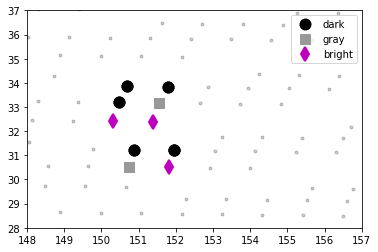

In [10]:
plot(alltiles['RA'], alltiles['DEC'], 'k.', alpha=0.2, label='_none_')
plot(explist['ra'][isdark], explist['dec'][isdark], 'o', color='k', ms=10, mew=2, label='dark')
plot(explist['ra'][isgray], explist['dec'][isgray], 's', color='0.6', ms=10, label='gray')
plot(explist['ra'][isbright], explist['dec'][isbright], 'd', color='m', ms=10, mew=2, label='bright')
legend(loc='upper right')
xlim(148, 157); ylim(28, 37)

In [11]:
nside = 64
pixels = desimodel.footprint.tiles2pix(nside, tiles)
nexp = np.count_nonzero(np.in1d(explist['tileid'], tiles['TILEID']))
print('{} tiles covered by {} exposures and {} healpixels'.format(len(tiles), nexp, len(pixels)))

10 tiles covered by 18 exposures and 47 healpixels


In [12]:
pixels

array([5261, 5262, 5263, 5272, 5273, 5274, 5275, 5278, 5281, 5283, 5284,
       5285, 5286, 5287, 5289, 5292, 5293, 5294, 5295, 5296, 5297, 5298,
       5299, 5300, 5301, 5302, 5303, 5304, 5305, 5306, 5307, 5308, 5309,
       5310, 5311, 5346, 5352, 5354, 5636, 5637, 5648, 5649, 5650, 5651,
       5652, 5653, 5654])

(28, 37)

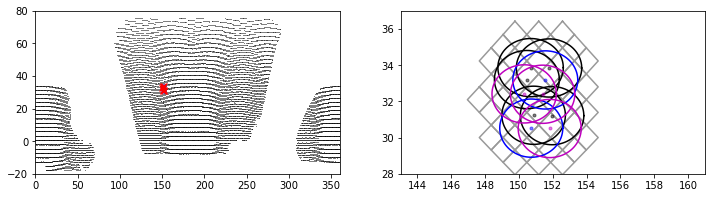

In [13]:
def plot_tile(ra, dec, r=1.606, color='k'):
    '''Approximate plot of tile location'''
    ang = np.linspace(0, 2*np.pi, 100)
    x = ra + r*np.cos(ang)/np.cos(np.radians(dec))
    y = dec + r*np.sin(ang)
    plot(x,y, '-', color=color)

def plot_healpix(nside, pixels):
    '''Plot healpix boundaries; doesn't work at RA wraparound'''
    for p in pixels:
        xyz = hp.boundaries(nside, p, nest=True)
        theta, phi = hp.vec2ang(xyz.T)
        theta = np.concatenate([theta, theta[0:1]])
        phi = np.concatenate([phi, phi[0:1]])
        ra, dec = np.degrees(phi), 90-np.degrees(theta)
        plot(ra, dec, '-', color='0.6')

figure(figsize=(12,3))
subplot(121)
plot(alltiles['RA'], alltiles['DEC'], 'k,', alpha=0.5)
plot(explist['ra'], explist['dec'], 'b.', alpha=0.5)
plot(tiles['RA'], tiles['DEC'], 'rx')
xlim(0,360); ylim(-20, 80)

subplot(122)
plot_healpix(nside, pixels)
color = dict(DARK='k', GRAY='b', BRIGHT='m')
for program in ['DARK', 'GRAY', 'BRIGHT']:
    ii = tiles['PROGRAM'] == program
    plot(tiles['RA'][ii], tiles['DEC'][ii], '.', color=color[program], alpha=0.5)
    jj = tiles['PROGRAM'] == program
    for t in tiles[jj]:
        plot_tile(t['RA'], t['DEC'], color=color[program])

xlim(143, 161); ylim(28, 37)

## Run select_mock_targets

This step combines mock catalogs with spectral templates per covered healpixel.
This notebook prints the commands to run in a separate cori login terminal to
get a 15 node interactive job, and then run the `mpi_select_mock_targets` command.
It should take ~15 minutes on 15 nodes.

In [14]:
import glob
def is_select_mock_targets_done(targetdir, pixels, verbose=False):
    done = True
    for filetype in ['target', 'truth', 'sky', 'standards-dark', 'standards-bright']:
        filenames = glob.glob(os.path.join(targetdir, '*', '*', '{}*.fits'.format(filetype)))
        if verbose:
            print('{}/{} {} files'.format(len(filenames), len(pixels), filetype))
        if len(filenames) != len(pixels):
            done = False
    return done

In [15]:
if is_select_mock_targets_done(targetdir, pixels):
    print("mpi_select_mock_targets already successfully run; skipping")
else:
    logfilename = os.path.join(targetdir, 'select_mock_targets.log')
    print('Running mpi_select_mock_targets batch job')
    print('Logging to {}'.format(logfilename))

    cmd = "srun -A desi -N 15 -n 30 -c 16 -C haswell -t 00:30:00 --qos interactive"
    cmd += " mpi_select_mock_targets --output_dir {targetdir} --config ./select-mock-targets.yaml"
    cmd += " --seed 1 --nproc 16 --nside 64 --tiles {tilefile}"
    cmd = cmd.format(targetdir=targetdir, tilefile=tilefile)
    
    with open(logfilename, 'a') as logfile:
        err = subprocess.call(cmd.split(), stderr=logfile, stdout=logfile)
        if err != 0:
            print('mpi_select_mock_targets failed err={}; see {}'.format(err, logfilename))
        else:
            print('done')
#     print('# Start an interactive job.')
#     print()
#     print('salloc -A desi -N 15 -t 00:30:00 -C haswell --qos interactive')
#     print()
#     print('# After your interactive node starts up,')
#     print()
#     print(envcmd)
#     print('cd {}'.format(minitestdir))
#     print(cmd)

Running mpi_select_mock_targets batch job
Logging to /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets/select_mock_targets.log
done


## Check that we got the right number of target output files ##
The number of files of each type should match the number of healpixels

In [16]:
if is_select_mock_targets_done(targetdir, pixels, verbose=True):
    print('Success')
else:
    print('ERROR: missing files')

47/47 target files
47/47 truth files
47/47 sky files
47/47 standards-dark files
47/47 standards-bright files
Success


## Merge target, sky, and stdstar catalogs

mpi_select_mock_targets writes targets per healpixel.  This step combines them into full catalogs (but the truth spectra themselves are still kept in individual healpix-organized files, otherwise they would be too big).
It also generates the "Merged Target List" (mtl) that assigns priorities to targets for fiberassignment.
This step is fast so is spawned directly from the notebook without requiring a batch job.

In [17]:
# cmd = "srun -N 4 -n 8 -c 16 -p debug -C haswell -t 00:05:00"
cmd = "join_mock_targets --mockdir {} --force".format(targetdir)
print(cmd)
err = subprocess.call(cmd.split())
if err != 0:
    print('join_mock_targets failed err={}'.format(err))
else:
    print('success')

join_mock_targets --mockdir /global/cscratch1/sd/sjbailey/desi/dev/end2end/targets --force
success


### Do some sanity checks on the results

In [18]:
targets = fitsio.read(os.path.join(targetdir, 'targets.fits'))
truth   = fitsio.read(os.path.join(targetdir, 'truth.fits'))
mtl     = fitsio.read(os.path.join(targetdir, 'mtl.fits'))
std     = fitsio.read(os.path.join(targetdir, 'standards-dark.fits'))
sky     = fitsio.read(os.path.join(targetdir, 'sky.fits'))

In [19]:
assert len(truth) == len(targets)                             #- same number of targets and truth
assert np.all(targets['TARGETID'] == truth['TARGETID'])       #- targets and truth are row matched
assert len(targets) == len(np.unique(targets['TARGETID']))    #- no repeated TARGETIDs
assert len(sky) == len(np.unique(sky['TARGETID']))            #- no repeated sky TARGETIDs
assert len(std) == len(np.unique(std['TARGETID']))            #- no repeated std TARGETIDs

assert np.all(np.in1d(targets['TARGETID'], mtl['TARGETID']))  #- all targets are in MTL

#- no sky targets should be in science targets, though it is possible for standards to also be MWS targets
assert not np.any(np.in1d(sky['TARGETID'], targets['TARGETID']))


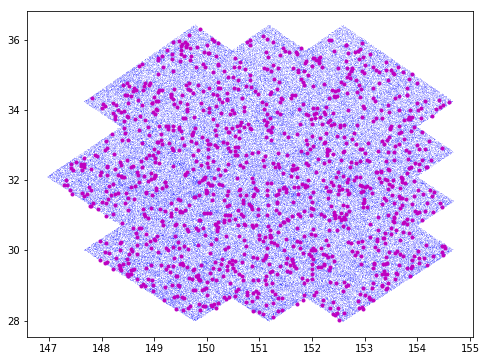

In [20]:
figure(figsize=(8,6))
plot(mtl['RA'], mtl['DEC'], 'b,', alpha=0.1)
plot(std['RA'], std['DEC'], 'm.')

## Run fiberassign

In [21]:
def is_fiberassign_done(fibassigndir, tiles, verbose=False):
    done = True
    for tileid in tiles['TILEID']:
        tilefile = os.path.join(fibassigndir, 'tile_{:05d}.fits'.format(tileid))
        if not os.path.exists(tilefile):
            done = False
            if verbose:
                print('Missing {}'.format(tilefile))

    return done

In [22]:
if is_fiberassign_done(fibassigndir, tiles):
    print('fiberassign already done; skipping')
else:
    print('Generating lists of dark and bright tiles')
    #- Write list of tiles to consider
    dx = open(os.path.join(fibassigndir, 'dark-tiles.txt'), 'w')
    bx = open(os.path.join(fibassigndir, 'bright-tiles.txt'), 'w')
    for tileid, program  in zip(tiles['TILEID'], tiles['PROGRAM']):
        if program == 'BRIGHT':
            bx.write(str(tileid)+'\n')
        else:
            dx.write(str(tileid)+'\n')

    dx.close()
    bx.close()

    #- Generate config files for dark and bright
    print('Generating fiberassign config files')
    cmd = "config-fiberassign "
    cmd += " --mtl {}/mtl.fits".format(targetdir)
    cmd += " --stdstars {}/standards-dark.fits".format(targetdir)
    cmd += " --sky {}/sky.fits".format(targetdir)
    cmd += " --surveytiles {}/dark-tiles.txt".format(fibassigndir)
    cmd += " --outdir {}".format(fibassigndir)
    cmd += " --config {}/fiberassign-config-dark.txt".format(fibassigndir)
    # print(cmd)
    err = subprocess.call(cmd.split())
    assert err == 0
    # !$cmd

    cmd = "config-fiberassign "
    cmd += " --mtl {}/mtl.fits".format(targetdir)
    cmd += " --stdstars {}/standards-bright.fits".format(targetdir)
    cmd += " --sky {}/sky.fits".format(targetdir)
    cmd += " --surveytiles {}/bright-tiles.txt".format(fibassigndir)
    cmd += " --outdir {}".format(fibassigndir)
    cmd += " --config {}/fiberassign-config-bright.txt".format(fibassigndir)
    # print(cmd)
    err = subprocess.call(cmd.split())
    assert err == 0
    # !$cmd

    #- Remove any leftover tile files
    for tilefile in glob.glob(fibassigndir+'/tile_*.fits'):
        os.remove(tilefile)

    #- Run fiberassign
    logfilename = os.path.join(fibassigndir, 'fiberassign.log')
    print('Running fiberassign; logging to {}'.format(logfilename))
    with open(logfilename, 'a') as logfile:
        cmd = "fiberassign {}/fiberassign-config-dark.txt".format(fibassigndir)
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('fiberassign failed err={}; see {}'.format(err, logfilename))

        cmd = "fiberassign {}/fiberassign-config-bright.txt".format(fibassigndir)
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('fiberassign failed err={}; see {}'.format(err, logfilename))

    if is_fiberassign_done(fibassigndir, tiles, verbose=True):
        print('Successfully ran fiberassign')
    else:
        print('ERROR: missing fiberassign output files')

Generating lists of dark and bright tiles
Generating fiberassign config files
Running fiberassign; logging to /global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/fiberassign.log
Successfully ran fiberassign


#### Run fiberassign QA ####
This will find non-fatal errors with unassigned fibers and too few standards

In [23]:
!qa-fiberassign $fibassigndir/tile*.fits --targets $targetdir/targets.fits

/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_01165.fits - ERROR
  Petal 6 has 7/10 stdstars
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_06927.fits - ERROR
  1 unassigned fibers
  Petal 5 has 6/10 stdstars
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_11108.fits - ERROR
  2 unassigned fibers
  Petal 0 has 9/10 stdstars
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_16870.fits - ERROR
  1 unassigned fibers
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_18465.fits - ERROR
  1 unassigned fibers
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_24227.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_28408.fits - OK
/global/cscratch1/sd/sjbailey/desi/dev/end2end/fiberassign/tile_34170.fits - ERROR
  5 unassigned fibers
  Petal 1 has 9/10 stdstars
  Petal 5 has 8/10 stdstars
  Petal 6 has 9/10 stdstars
  Petal 8 has 6/10 stdstars
/global/cscratch1/sd/sjbailey/desi/d

## Run newexp to combine surveysim, mocks, and fiberassign into simspec files

Setup the problem and define the commands to run, but then run them
in a separate window with desisim/newexp configured.

This step associates exposure IDs (EXPID) to observations and inserts 3 arcs and 3 flats
at the beginning of each night.

specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

4.4 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes.

In [24]:
def is_newexp_done(explist, simdatadir, verbose=False):
    numnights = len(set(explist['night']))
    nexp = 6*numnights + len(explist)  #- 3 arc/night + 3 flat/night + science
    simspecfiles = glob.glob(simdatadir+'/*/simspec*.fits')
    fibermapfiles = glob.glob(simdatadir+'/*/fibermap*.fits')
    if verbose:
        print('{}/{} simspec files'.format(len(simspecfiles), nexp))
        print('{}/{} fibermap files'.format(len(fibermapfiles), nexp))

    if len(simspecfiles) != nexp:
        return False
    elif len(fibermapfiles) != nexp:
        return False
    else:
        return True

# is_newexp_done(explist, simdatadir)

In [25]:
if is_newexp_done(explist, simdatadir):
    print('newexp already done; skipping')
else:
    logfilename = os.path.join(simdatadir, 'newexp.log')
    print('Running wrap-newexp batch job; should take ~5 min')
    print('Starting at {}'.format(time.asctime()))
    print('Logging to {}'.format(logfilename))
    nodes = 15

    cmd = "srun -A desi -N {nodes} -n {nodes} -c 32".format(nodes=nodes)
    cmd += " -C haswell -t 00:15:00 --qos interactive"
    cmd += " wrap-newexp --mpi --fiberassign {}".format(fibassigndir)
    cmd += " --mockdir {}".format(targetdir)
    cmd += " --obslist {}/exposures.fits".format(surveydir)
    cmd += " --tilefile {}".format(tilefile)
    # print(cmd)
    
    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('ERROR {} running wrap-newexp; see {}'.format(err, logfile))
        else:
            print('done')


Running wrap-newexp batch job; should take ~5 min
Starting at Sun Nov  5 09:28:08 2017
Logging to /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/sim/mini/newexp.log
done


### Confirm that we got the expected newexp output files

In [26]:
if is_newexp_done(explist, simdatadir, verbose=True):
    print('Success')
else:
    print('ERROR: Missing files')

42/42 simspec files
42/42 fibermap files
Success


## Run fastframe to generate noisy uncalibrated spectra

fastframe is a stripped down version of quickgen, and it uses specsim under the hood.
specsim is memory hungry so we are limited to one process per node, leaving
the other cores idle.

6.3 minutes for 12 arc, 12 flat, 18 science exposures on 15 nodes

In [27]:
def is_fastframe_done(explist, reduxdir, verbose=False):
    numnights = len(set(explist['night']))
    nframe = 30*(3*numnights + len(explist))  #- 3 flat/night + science frames
    framefiles = glob.glob(reduxdir+'/exposures/*/*/frame*.fits')
    if verbose:
        print('{}/{} frame files'.format(len(framefiles), nframe))
    
    if len(framefiles) != nframe:
        return False
    else:
        return True

is_fastframe_done(explist, reduxdir, verbose=True)


0/900 frame files


False

In [28]:
if is_fastframe_done(explist, reduxdir):
    print('fastframe already done; skipping')
else:
    logfilename = os.path.join(reduxdir, 'exposures', 'fastframe.log')
    os.makedirs(os.path.dirname(logfilename), exist_ok=True)
    print('Running fastframe batch job; should take ~7 min')
    print('Starting at {}'.format(time.asctime()))
    print('Logging to {}'.format(logfilename))
    nodes = 15

    cmd = "srun -A desi -N {nodes} -n {nodes} -c 32 -C haswell -t 00:20:00 --qos interactive".format(nodes=nodes)
    cmd += " wrap-fastframe --mpi"
    with open(logfilename, 'w') as logfile:
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('ERROR {} running wrap-fastframe; see {}'.format(err, logfilename))
        else:
            print('done')

Running fastframe batch job; should take ~7 min
Starting at Sun Nov  5 09:32:32 2017
Logging to /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/exposures/fastframe.log
done


In [29]:
#- Check individual framefile outputs
import desispec.io
ntot = 0
nbad = 0
for night in set(explist['night']):
    try:
        night = night.replace('-', '')
    except TypeError:
        night = night.decode().replace('-', '')
        
    fibermapfiles = glob.glob(os.path.join(simdatadir, night, 'fibermap*.fits'))
    for fmfile in fibermapfiles:
        hdr = fits.getheader(fmfile, 1)
        if hdr['FLAVOR'] in ('science', 'flat'):
            expid = hdr['EXPID']
            for channel in ['b', 'r', 'z']:
                for spectrograph in range(10):
                    camera = channel + str(spectrograph)
                    framefile = desispec.io.findfile('frame', night, expid, camera)
                    ntot += 1
                    if not os.path.exists(framefile):
                        nbad += 1
                        print('Missing', framefile)

if nbad > 0:
    print('Missing {}/{} frame files'.format(nbad, ntot))
else:
    print('All {} science and flat frame files generated'.format(ntot))

All 900 science and flat frame files generated


## Run the spectro pipeline

  * generate the production scripts
  * launch them

The pipeline massively overestimates the time to run each step, so at submission time dial the time back to just 10 minutes.

In [30]:
def is_cframe_done(explist, reduxdir, verbose=False):
    numnights = len(set(explist['night']))
    nframe = 30*len(explist)  #- 30 frames/science, no calibrated arcs or flats
    cframefiles = glob.glob(reduxdir+'/exposures/*/*/cframe*.fits')
    if verbose:
        print('{}/{} cframe files'.format(len(cframefiles), nframe))
    
    if len(cframefiles) != nframe:
        return False
    else:
        return True

is_cframe_done(explist, reduxdir, verbose=True)

0/540 cframe files


False

In [31]:
#- Equivalent to running `desi_pipe` from the command line
if is_cframe_done(explist, reduxdir):
    print('Spectro pipeline done; skipping planning')
else:
    from desispec.scripts import pipe_prod
    args = pipe_prod.parse('--nersc_host cori --nersc_queue debug --fakepix'.split())
    pipe_prod.main(args)
    print('done')

/global/common/cori/contrib/desi/desiconda/20170613-1.1.4-spectro/code/desiconda/20170613-1.1.4-spectro_conda/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Working with production /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini :
  Updating plans ...
  Creating setup.sh ...
  Selecting nights ...
  Finding max processes supported by workers ...
    bootstrap : 1 processes per task
    psf : 20 processes per task
    psfcombine : 1 processes per task
    extract : 20 processes per task
    fiberflat : 1 processes per task
    sky : 1 processes per task
    stdstars : 1 processes per task
    fluxcal : 1 processes per task
    calibrate : 1 processes per task
    redshift : 16 processes per task
  Generating scripts ...
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
113 nodes too big for debug queue; switching to regular
65 minutes too big for debug queue; switching to regular
65 minutes too big for debug queue; switching to regular
65 minutes too big for debug queue; switching to regular
65 minutes too 

In [32]:
#- Find nights that observed these tiles
try:
    nights = unique(np.char.replace(explist['night'], '-', ''))
except TypeError:
    nights = unique(np.char.replace(np.char.decode(explist['night']), '-', ''))
print(nights)

['20200315' '20200316' '20200318' '20200319']


In [33]:
#- Equivalent to running `desi_pipe` from the command line
if is_cframe_done(explist, reduxdir):
    print('Spectro pipeline done; skipping launching jobs')
else:
    for night in nights:
        launchcmd = 'sbatch -A desi --time 00:10:00 -p debug {reduxdir}/run/scripts/{night}/fiberflat-calibrate_{night}.slurm'.format(
            reduxdir=reduxdir, night=night
        )
        print(launchcmd)
        err = subprocess.call(launchcmd.split())
        if err != 0:
            print('ERROR {} while launching {}'.format(err, night))
    print('done')

sbatch -A desi --time 00:10:00 -p debug /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200315/fiberflat-calibrate_20200315.slurm
sbatch -A desi --time 00:10:00 -p debug /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200316/fiberflat-calibrate_20200316.slurm
sbatch -A desi --time 00:10:00 -p debug /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200318/fiberflat-calibrate_20200318.slurm
sbatch -A desi --time 00:10:00 -p debug /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/scripts/20200319/fiberflat-calibrate_20200319.slurm
done


In [34]:
#- Monitor queue until those jobs are done
def count_jobs(jobname):
    cmd = 'squeue -u {}'.format(os.getenv('USER'))
    proc = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = proc.communicate()
    njob = 0
    for line in stdout.split(b'\n'):
        if line.find(jobname) > 0:
            njob += 1

    return njob

print('To check details, run this on cori.nersc.gov:')
print('    squeue -u {}'.format(os.getenv('USER')))
n = count_jobs(b'debug fiberfla')
while n > 0:
    nsleep = n*2
    print('{} jobs still queued or running; sleeping {} minutes'.format(n, nsleep))
    time.sleep(nsleep*60)
    n = count_jobs(b'debug fiberfla')
print('All jobs finished')

To check details, run this on cori.nersc.gov:
    squeue -u sjbailey
4 jobs still queued or running; sleeping 5 minutes
4 jobs still queued or running; sleeping 5 minutes
2 jobs still queued or running; sleeping 5 minutes
All jobs finished


### Check that we got expected outputs
This includes both calibration and science exposures

In [35]:
ii = np.in1d(explist['tileid'], tiles['TILEID'])
nsci = len(explist[ii])
nflat = 3*len(nights)
nframe = 30*(nsci+nflat)
ncframe = 30*nsci
framefiles = sorted(glob.glob('{}/exposures/*/*/frame*.fits'.format(reduxdir)))
cframefiles = sorted(glob.glob('{}/exposures/*/*/cframe*.fits'.format(reduxdir)))
print('frame {}/{}, cframe {}/{}'.format(len(framefiles), nframe, len(cframefiles), ncframe))

if len(framefiles) != nframe:
    print('ERROR: missing frame files')
if len(cframefiles) != ncframe:
    print('ERROR: missing cframe files')

frame 900/900, cframe 540/540


## Regroup spectra from frames -> healpix

The data so far are grouped on disk by exposure in calibrated frame files.
Regroup into sets of spectra in the same healpix on the sky.

This script is asking for 1 node for 2 hours (!).  Try running as interactive job on 6 nodes with 8 workers per node.  ~20 minutes.

In [36]:
def is_regrouping_done(pixels, reduxdir):
    specfiles = glob.glob(reduxdir+'/spectra-*/*/*/spectra-*.fits')
    #- some pixels might not be covered by real data, but most should be
    if len(specfiles) < len(pixels) - 5:
        return False
    else:
        return True

is_regrouping_done(pixels, reduxdir)

False

In [37]:
if is_regrouping_done(pixels, reduxdir):
    print('Spectra regrouping by healpix already done; skipping')
else:
    logfilename = os.path.join(reduxdir, 'run', 'logs', 'regroup.log')
    print('Running batch job to regrouping spectra by healpix')
    print('Should take ~20 minutes; starting at {}'.format(time.asctime()))
    print('Logging to {}'.format(logfilename))
    os.environ['TMPDIR'] = '/dev/shm'
    with open(logfilename, 'w') as logfile:
        cmd = 'srun -A desi -N 6 -n 48 -c 8 -t 1:00:00 -C haswell --qos interactive --cpu_bind=cores'
        cmd += ' desi_group_spectra --pipeline'
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('ERROR {} while regrouping; see {}'.format(err, logfilename))
        else:
            print('done')

Running batch job to regrouping spectra by healpix
Should take ~20 minutes; starting at Sun Nov  5 09:53:29 2017
Logging to /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/logs/regroup.log
done


In [38]:
if is_regrouping_done(pixels, reduxdir):
    print('success')
else:
    print('ERROR: too many missing spectra files')

success


## Did all pixels make it from sims -> output spectra?

It looks like tiles2pix was conservative and included some edge pixels that weren't
really necessary.

Missing spectra-64-5636.fits


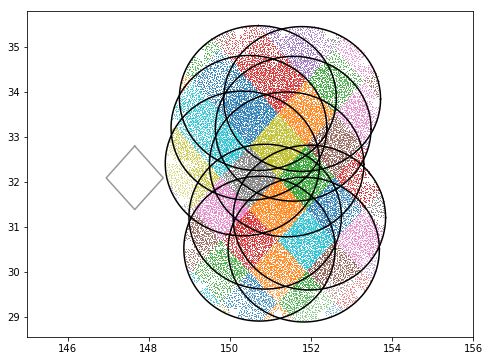

In [39]:
import desispec.io
nside=64
misspix = list()
figure(figsize=(8,6))
for p in pixels:
    specfile = desispec.io.findfile('spectra', nside=nside, groupname=str(p))
    if not os.path.exists(specfile):
        print('Missing {}'.format(os.path.basename(specfile)))
        misspix.append(p)
    else:
        fibermap = Table.read(specfile, 'FIBERMAP')
        plot(fibermap['RA_TARGET'], fibermap['DEC_TARGET'], ',', alpha=0.5)

plot_healpix(nside, misspix)
for t in tiles:
    plot_tile(t['RA'], t['DEC'])

tmp = xlim(145, 156)

## Run redrock redshift fitting

desispec/0.16.0 has a bug in how spectra are distributed over MPI ranks for the pipeline wrapper of redrock.
Bypass this by using the `two_percent_DESI/mini/wrap-redrock` script.  Takes ~30 min.

In [40]:
def is_redrock_done(reduxdir, verbose=False):
    specfiles = glob.glob(reduxdir+'/spectra-*/*/*/spectra*.fits')
    zbestfiles = glob.glob(reduxdir+'/spectra-*/*/*/zbest*.fits')
    if verbose:
        print('{}/{} zbest files'.format(len(zbestfiles), len(specfiles)))
    if len(zbestfiles) != len(specfiles):
        return False
    else:
        return True

is_redrock_done(reduxdir, verbose=True)

0/46 zbest files


False

In [41]:
if is_redrock_done(reduxdir):
    print('redrock already done; skipping')
else:
    nodes = 15
    logfilename = os.path.join(reduxdir, 'run', 'logs', 'redrock.log')
    print('Running redrock batch job')
    print('Should take ~30 minutes; starting at {}'.format(time.asctime()))
    print('Logging to {}'.format(logfilename))
    with open(logfilename, 'w') as logfile:
        cmd = 'srun -A desi -N {nodes} -n {nodes} -c 64 -t 1:00:00 -C haswell --qos interactive --cpu_bind=cores'
        cmd += ' {minitestdir}/wrap-redrock --mpi --ncpu 32'
        cmd = cmd.format(nodes=nodes, minitestdir=minitestdir)
        err = subprocess.call(cmd.split(), stdout=logfile, stderr=logfile)
        if err != 0:
            print('redrock returned error {}; see {}'.format(err, logfilename))
        else:
            print('done')

Running redrock batch job
Should take ~30 minutes; starting at Sun Nov  5 10:13:37 2017
Logging to /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/run/logs/redrock.log
done


### Check redrock output

In [42]:
import desitarget.io
zbestfiles = list(desitarget.io.iter_files(reduxdir, 'zbest'))
specfiles = list(desitarget.io.iter_files(reduxdir, 'spectra'))
print('{}/{} zbest files created'.format(len(zbestfiles), len(specfiles)))
for spfile in specfiles:
    zbfile = spfile.replace('spectra-64-', 'zbest-64-')
    if zbfile not in zbestfiles:
        print('MISSING {}'.format(zbfile))

46/46 zbest files created


### Count number of spectra and targets per healpix

In [43]:
import desispec.io

specdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'], 'spectra-64')
specfiles = list()
for specfile in sorted(list(desitarget.io.iter_files(specdir, 'spectra'))):
    fm = desispec.io.read_fibermap(specfile)
    ntarg = len(np.unique(fm['TARGETID']))
    nspec = len(fm) * 3
    specfiles.append( (ntarg, nspec, os.path.basename(specfile)) )

In [44]:
print('==================== ===== ========')
print('specfile             nspec ntargets')
print('==================== ===== ========')
for ntarg, nspec, specfile in sorted(specfiles):
    print("{0:20s} {1:5d} {2:8d}".format(os.path.basename(specfile), nspec, ntarg))
print('==================== ===== ========')

==================== ===== ========
specfile             nspec ntargets
==================== ===== ========
spectra-64-5289.fits    36        6
spectra-64-5301.fits    66       11
spectra-64-5281.fits   114       19
spectra-64-5294.fits   120       39
spectra-64-5650.fits   264       41
spectra-64-5261.fits   138       46
spectra-64-5354.fits   312       52
spectra-64-5273.fits   171       57
spectra-64-5654.fits   360       60
spectra-64-5346.fits   486       81
spectra-64-5283.fits   498       83
spectra-64-5262.fits   435       94
spectra-64-5278.fits  1218      136
spectra-64-5653.fits   978      139
spectra-64-5272.fits   528      176
spectra-64-5651.fits  1086      177
spectra-64-5352.fits  1302      217
spectra-64-5637.fits  1194      283
spectra-64-5292.fits  3582      588
spectra-64-5300.fits  4683      719
spectra-64-5284.fits  3870      741
spectra-64-5303.fits  4863      803
spectra-64-5652.fits  6090      826
spectra-64-5311.fits  5928      841
spectra-64-5263.fits  4134  

## Create zcatalog

This is just a merging of the individual zbest files

In [45]:
cmd = 'desi_zcatalog -i {reduxdir}/spectra-64 -o {reduxdir}/zcatalog.fits'.format(reduxdir=reduxdir)
print(cmd)
!$cmd

desi_zcatalog -i /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/spectra-64 -o /global/cscratch1/sd/sjbailey/desi/dev/end2end/spectro/redux/mini/zcatalog.fits


## Redshift QA

In [46]:
truth = Table.read(os.path.join(targetdir, 'truth.fits'))
zcat = Table.read(os.path.join(reduxdir, 'zcatalog.fits'))

truth['TRUESPECTYPE'] = np.char.strip(truth['TRUESPECTYPE'])
truth['TEMPLATETYPE'] = np.char.strip(truth['TEMPLATETYPE'])
zcat['SPECTYPE'] = np.char.strip(zcat['SPECTYPE'])

In [47]:
import astropy.table
del zcat.meta['EXTNAME']
del truth.meta['EXTNAME']
ztruth = astropy.table.join(zcat, truth, keys='TARGETID')

In [48]:
isELG = (ztruth['TEMPLATETYPE'] == 'ELG')
isQSO = (ztruth['TEMPLATETYPE'] == 'QSO')
isLRG = (ztruth['TEMPLATETYPE'] == 'LRG')
isSTAR = (ztruth['TEMPLATETYPE'] == 'STAR')
isBGS = (ztruth['TEMPLATETYPE'] == 'BGS')
print('QSO ', np.count_nonzero(isQSO))
print('LRG ', np.count_nonzero(isLRG))
print('ELG ', np.count_nonzero(isELG))
print('STAR', np.count_nonzero(isSTAR))
print('BGS ', np.count_nonzero(isBGS))

QSO  3088
LRG  5245
ELG  17996
STAR 2034
BGS  12468


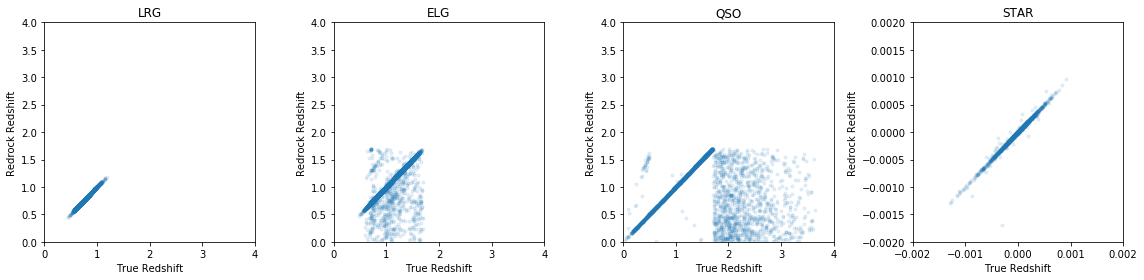

In [49]:
def plotz(ztruth, label, zmin=0.0, zmax=1.5, ylabel_=None):
    plot(ztruth['TRUEZ'], ztruth['Z'], '.', label=label, alpha=0.1)
    title(label)
    xlim(zmin, zmax); ylim(zmin, zmax)
    xlabel('True Redshift')
    ylabel('Redrock Redshift')

figure(figsize=(16,4))
subplot(141); plotz(ztruth[isLRG], 'LRG', zmax=4)
subplot(142); plotz(ztruth[isELG], 'ELG', zmax=4)
subplot(143); plotz(ztruth[isQSO], 'QSO', zmax=4)
subplot(144); plotz(ztruth[isSTAR], 'STAR', zmin=-0.002, zmax=0.002)
tight_layout()

In [50]:
def zstats(zx, dvlimit=1000, count=False):
    dv = 1e5 * (zx['Z'] - zx['TRUEZ'])/(1+zx['TRUEZ'])
    good = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] == 0)
    fail = (np.abs(dv)> dvlimit) & (zx['ZWARN'] == 0)
    miss = (np.abs(dv)<=dvlimit) & (zx['ZWARN'] != 0)
    lost = (np.abs(dv)> dvlimit) & (zx['ZWARN'] != 0)
    ngood = np.count_nonzero(good)
    nfail = np.count_nonzero(fail)
    nmiss = np.count_nonzero(miss)
    nlost = np.count_nonzero(lost)
    ntot = len(dv)
    assert(ntot == ngood+nfail+nmiss+nlost)
    if count:
        return ngood, nfail, nmiss, nlost
    elif ntot == 0:
        return (np.nan, np.nan, np.nan, np.nan)
    else:
        return 100*ngood/ntot, 100*nfail/ntot, 100*nmiss/ntot, 100*nlost/ntot

print('          ntarg   good  fail  miss  lost')
for objtype in set(ztruth['TEMPLATETYPE']):
    isx = (ztruth['TEMPLATETYPE'] == objtype)
    pgood, pfail, pmiss, plost = zstats(ztruth[isx])
    nx = np.count_nonzero(isx)
    print('{:6s} {:8d}  {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(objtype, nx, pgood, pfail, pmiss, plost))

print()
print('good = correct redshift and ZWARN==0')
print('fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)')
print('miss = correct redshift ZWARN!=0 (missed opportunities)')
print('lost = wrong redshift ZWARN!=0 (wrong but at least we know it)')

          ntarg   good  fail  miss  lost
QSO        3088   60.3   2.6   1.0  36.2
ELG       17996   91.3   0.4   4.4   3.9
STAR       2034   82.2   0.4   3.0  14.4
LRG        5245  100.0   0.0   0.0   0.0
WD           88   87.5  10.2   0.0   2.3
BGS       12468   99.6   0.0   0.3   0.1

good = correct redshift and ZWARN==0
fail = bad redshift and ZWARN==0 (i.e. catastrophic failures)
miss = correct redshift ZWARN!=0 (missed opportunities)
lost = wrong redshift ZWARN!=0 (wrong but at least we know it)


## What happened to the high-z QSOs?

This is a bug in the QSO template generation in desispec 16.0 included in the desimodules 17.9 release.

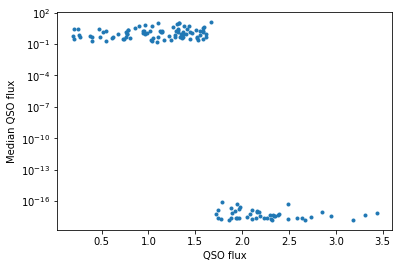

In [51]:
from astropy.io import fits
targetfile = os.path.join(targetdir, '53', '5300', 'truth-64-5300.fits')
xflux = fits.getdata(targetfile, 'FLUX')
xtrue = Table.read(targetfile, 'TRUTH')
isqso = xtrue['TRUESPECTYPE'] == 'QSO'
xflux = xflux[isqso]
xtrue = xtrue[isqso]
tmpflux = np.median(xflux, axis=1)

plot(xtrue['TRUEZ'], tmpflux, '.')
semilogy()
xlabel('QSO flux'); ylabel('Median QSO flux')

## Study QSO efficiency vs. FLUX_G

The failures are dominated by z>1.7 input spectra with the wrong flux units, but the lowz QSOs
are so efficient that is isn't very meaningful to bin them.  Leaving this code in here for now in case it is useful in a later update.

In [52]:
g = ztruth['FLUX_G']
magbins = np.linspace(16, 24, 17)
midmag = 0.5*(magbins[0:-1] + magbins[1:])
zeff = list()
for i in range(len(magbins)-1):
    maglo, maghi = magbins[i:i+2]
    ismag = (maglo < g) & (g < maghi)
    pgood, pfail, pmiss, plost = zstats(ztruth[isQSO & ismag])
    nmag = np.count_nonzero(isQSO & ismag)
    print('{:.1f}-{:.1f} {:4d} {:6s} {:5.1f} {:5.1f} {:5.1f} {:5.1f}'.format(maglo, maghi, nmag, 'QSO', pgood, pfail, pmiss, plost))
    zeff.append(pgood)


16.0-16.5    9 QSO     77.8   0.0   0.0  22.2
16.5-17.0   15 QSO     86.7   6.7   0.0   6.7
17.0-17.5    6 QSO     66.7  16.7   0.0  16.7
17.5-18.0    5 QSO     80.0   0.0   0.0  20.0
18.0-18.5    2 QSO    100.0   0.0   0.0   0.0
18.5-19.0    8 QSO     62.5  12.5   0.0  25.0
19.0-19.5    4 QSO     50.0  25.0   0.0  25.0
19.5-20.0    7 QSO     71.4   0.0   0.0  28.6
20.0-20.5    7 QSO     85.7   0.0   0.0  14.3
20.5-21.0    4 QSO    100.0   0.0   0.0   0.0
21.0-21.5    2 QSO    100.0   0.0   0.0   0.0
21.5-22.0    8 QSO     87.5   0.0   0.0  12.5
22.0-22.5    6 QSO    100.0   0.0   0.0   0.0
22.5-23.0    3 QSO     66.7   0.0   0.0  33.3
23.0-23.5    5 QSO     80.0   0.0   0.0  20.0
23.5-24.0    8 QSO     50.0   0.0   0.0  50.0


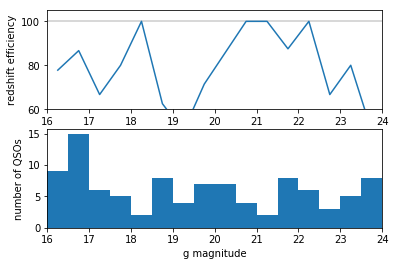

In [53]:
subplot(211)
axhline(100, color='0.8')
plot(midmag, zeff)
xlim(magbins[0], magbins[-1])
ylabel('redshift efficiency')
ylim(60,105)

subplot(212)
hist(g[isQSO], len(magbins)-1, (magbins[0], magbins[-1]))
xlim(magbins[0], magbins[-1])
xlabel('g magnitude')
ylabel('number of QSOs')

In [54]:
print("Done at {}".format(time.asctime()))
run_time = time.time() - start_time
print("That took {:.1f} minutes".format(run_time/60))

Done at Sun Nov  5 10:57:57 2017
That took 102.9 minutes


# TODO

A wishlist of things to add to this notebook (but not necessarily blocking factors for merging)
* Target selection QA
* spectro pipeline QA
* other QA?